## Synaptic plasticity in Pointnet (STP, facilitation, depression, STDP, and others)

In the NEST simulator, the available postsynaptic current or conductance waveforms (alpha, exp, or delta) are typically integrated into the _neuron model_. The _synapse model_ allows for more sophisticated and varied built-in models of synapses, such as dynamic synapses or gap junctions.

A list of available synapse models is listed here:
https://nest-simulator.readthedocs.io/en/v2.18.0/models/synapses.html

So far, we have been using "static_synapse" (which simply stores target, weight, delay and receiver port). In this mini-tutorial, we will show an example of how to implement facilitation and depression using BMTK.


In [1]:
import matplotlib.pyplot as plt
import nest
import numpy as np
import os
import glob

from bmtk.builder.networks import NetworkBuilder
from bmtk.simulator import pointnet
from bmtk.analyzer.compartment import plot_traces
from bmtk.analyzer.spike_trains import plot_raster


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-3.0
 Built: Sep 14 2022 22:43:51

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



First, we will create a two neuron network. The presynaptic neuron is a simple integrate-and-fire neuron. If we open the dynamics_params file ```472363762_point_with_cc.json``` within _/components/point_neuron_models_, we see that the parameter **I_e** has been set to 190.0, which injects a constant background current, triggering regular firing in the presynaptic neuron.        

```json
{
  "I_e": 190.0,
  "tau_m": 44.9,
  "C_m": 239.0,
  "t_ref": 3.0,
  "E_L": -78.0,
  "V_th": -43.0,
  "V_reset": -55.0
}
```


In [2]:
net = NetworkBuilder('two_cell')

# Build Nodes

net.add_nodes(
    N=1,
    model_type='point_neuron',
    model_template= 'nest:iaf_psc_alpha',
    dynamics_params='472363762_point_with_cc.json',
    ei_type='e',
    pop_name='presyn'
)

net.add_nodes(
    N=1,
    model_type='point_neuron',
    model_template= 'nest:glif_lif_asc_psc',
    dynamics_params='Scnn1a_515806250_glif_lif_asc.json',
    ei_type='e',
    pop_name='postsyn'
)

We will add a 'static_synapse' connection between the neurons so we can first see the baseline behavior of the network with an inhibitory static synapse.

In [3]:
# Build edge

net.add_edges(
    source=net.nodes(pop_name='presyn'),
    target=net.nodes(pop_name='postsyn'),
    connection_rule = 1,
    model_template='static_synapse',
    dynamics_params='static_ExcToExc.json',     
    delay=2.0,
    syn_weight=-100
)

net.build()
net.save(output_dir='network')

In [4]:
from bmtk.utils.create_environment import create_environment

create_environment(
    'pointnet',
    base_dir='.',
    config_file='config.pointnet.json',
    network_dir='network',
    output_dir='output_pointnet',
    tstop=3000.0, dt=0.1,
    report_vars=['V_m'],
    run_script='run_pointnet.py',
    overwrite=True,
)


In [5]:
configure = pointnet.Config.from_json('config.pointnet.json')
configure.build_env()

network = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, network)
sim.run()


2022-10-28 17:19:35,013 [INFO] Created log file


INFO:NestIOUtils:Created log file


2022-10-28 17:19:35,033 [INFO] Batch processing nodes for two_cell/0.


INFO:NestIOUtils:Batch processing nodes for two_cell/0.


2022-10-28 17:19:35,051 [INFO] Setting up output directory


INFO:NestIOUtils:Setting up output directory


2022-10-28 17:19:35,054 [INFO] Building cells.


INFO:NestIOUtils:Building cells.


2022-10-28 17:19:35,062 [INFO] Building recurrent connections


INFO:NestIOUtils:Building recurrent connections


2022-10-28 17:19:35,069 [INFO] Network created.


INFO:NestIOUtils:Network created.


2022-10-28 17:19:35,077 [INFO] Starting Simulation


INFO:NestIOUtils:Starting Simulation


2022-10-28 17:19:35,198 [INFO] Simulation finished, finalizing results.


INFO:NestIOUtils:Simulation finished, finalizing results.


2022-10-28 17:19:35,247 [INFO] Done.


INFO:NestIOUtils:Done.


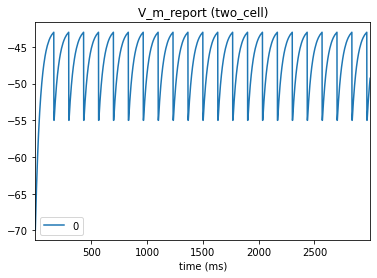

In [6]:
# Presynaptic cell
_ = plot_traces(config_file='config.pointnet.json', report_name='V_m_report', node_ids = [0])

Our background current produces regular firing in the presynaptic cell. Note that for LIF models the spike itself is not shown and just produces a reset of the membrane potential.

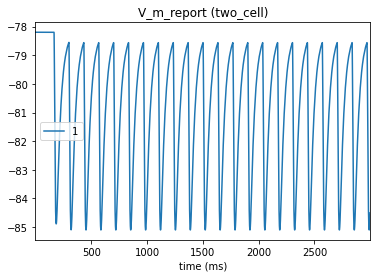

In [7]:
# Postsynaptic cell
_ = plot_traces(config_file='config.pointnet.json', report_name='V_m_report', node_ids = [1])

In the postsynaptic cell, we can see the summation of a series of IPSPs triggered by each presynaptic spike (note that the postsynaptic effect is modeled as a current but produces the voltage effect seen here).

Next, we'll try rebuilding the network, this time with a facilitating synapse based on the "tsodyks2_synapse" model. This model is described in more detail at:

https://nest-simulator.readthedocs.io/en/stable/auto_examples/evaluate_tsodyks2_synapse.html

as well as on the synapses documentation page linked at the top. 

In [8]:
# Clear the network folder

for f in glob.glob('network/*'):
    try:
        os.remove(f)
    except FileNotFoundError as fnfe:
        pass

In [9]:
net2 = NetworkBuilder('two_cell_fac')

# Build Nodes

net2.add_nodes(
    N=1,
    model_type='point_neuron',
    model_template= 'nest:iaf_psc_alpha',
    dynamics_params='472363762_point_with_cc.json',
    ei_type='e',
    pop_name='presyn'
)

net2.add_nodes(
    N=1,
    model_type='point_neuron',
    model_template= 'nest:glif_lif_asc_psc',
    dynamics_params='Scnn1a_515806250_glif_lif_asc.json',
    ei_type='e',
    pop_name='postsyn'
)

In [10]:
net2.add_edges(
    source=net2.nodes(pop_name='presyn'),
    target=net2.nodes(pop_name='postsyn'),
    connection_rule = 1,   
    model_template='tsodyks2_synapse',
    dynamics_params='TsodyksFac_glif.json',  
    delay=2.0,
    syn_weight=-100
)

net2.build()
net2.save(output_dir='network')

We have created a new dynamics_params file ```tsodyksFac_glif.json``` based on the dynamic_params file for the static synapse and have added to it the following params for the tsodyks2 synapse:

```json
{
        "U": 0.1, 
        "u": 0.1, 
        "x": 1.0,
        "tau_rec": 100.0,
        "tau_fac": 1000.0, 
        "weight": 250.0,
}
```

In [11]:
create_environment(
    'pointnet',
    base_dir='.',
    config_file='config.pointnet.json',
    network_dir='network',
    output_dir='output_pointnet',
    tstop=3000.0, dt=0.1,
    report_vars=['V_m'],
    run_script='run_pointnet.py',
    overwrite=True,
)

In [12]:
configure = pointnet.Config.from_json('config.pointnet.json')
configure.build_env()

network = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, network)
sim.run()

2022-08-24 15:19:25,464 [INFO] Created log file


INFO:NestIOUtils:Created log file


2022-08-24 15:19:25,476 [INFO] Batch processing nodes for two_cell_fac/0.


INFO:NestIOUtils:Batch processing nodes for two_cell_fac/0.


2022-08-24 15:19:25,491 [INFO] Setting up output directory


INFO:NestIOUtils:Setting up output directory


2022-08-24 15:19:25,492 [INFO] Building cells.


INFO:NestIOUtils:Building cells.


2022-08-24 15:19:25,499 [INFO] Building recurrent connections


INFO:NestIOUtils:Building recurrent connections


2022-08-24 15:19:25,505 [INFO] Network created.


INFO:NestIOUtils:Network created.


2022-08-24 15:19:25,509 [INFO] Starting Simulation


INFO:NestIOUtils:Starting Simulation


2022-08-24 15:19:25,654 [INFO] Simulation finished, finalizing results.


INFO:NestIOUtils:Simulation finished, finalizing results.


2022-08-24 15:19:25,697 [INFO] Done.


INFO:NestIOUtils:Done.


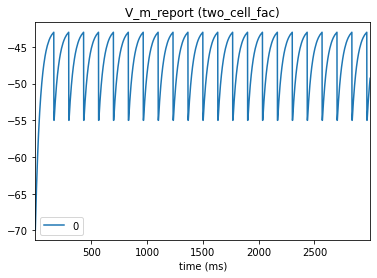

In [13]:
# Presynaptic cell
_ = plot_traces(config_file='config.pointnet.json', report_name='V_m_report', node_ids = [0])

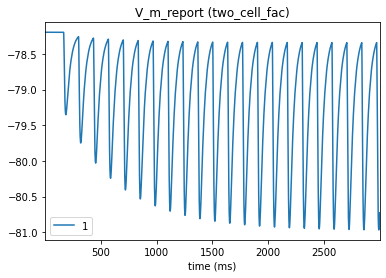

In [14]:
# Postsynaptic cell
_ = plot_traces(config_file='config.pointnet.json', report_name='V_m_report', node_ids = [1])

This time, the IPSP's get incrementally larger as they occur closely in succession, simulating synaptic facilitation. We can use the same model, just changing the parameters, to create a depressing synapse. We will add these parameter values to the dynamic_params:

```json
{
        "U": 0.67, 
        "u": 0.67, 
        "x": 1.0,
        "tau_rec": 450.0,
        "tau_fac": 0.0, 
        "weight": 250.0
}
```

In [15]:
# Clear the network folder

for f in glob.glob('network/*'):
    try:
        os.remove(f)
    except FileNotFoundError as fnfe:
        pass

In [16]:
net3 = NetworkBuilder('two_cell_dep')

# Build Nodes

net3.add_nodes(
    N=1,
    model_type='point_neuron',
    model_template= 'nest:iaf_psc_alpha',
    dynamics_params='472363762_point_with_cc.json',
    ei_type='e',
    pop_name='presyn'
)

net3.add_nodes(
    N=1,
    model_type='point_neuron',
    model_template= 'nest:glif_lif_asc_psc',
    dynamics_params='Scnn1a_515806250_glif_lif_asc.json',
    ei_type='e',
    pop_name='postsyn'
)

In [17]:
net3.add_edges(
    source=net3.nodes(pop_name='presyn'),
    target=net3.nodes(pop_name='postsyn'),
    connection_rule = 1,   
    model_template='tsodyks2_synapse',
    dynamics_params='TsodyksDep_glif.json',   
    delay=2.0,
    syn_weight=-100
)

net3.build()
net3.save(output_dir='network')

In [18]:
create_environment(
    'pointnet',
    base_dir='.',
    config_file='config.pointnet.json',
    network_dir='network',
    output_dir='output_pointnet',
    tstop=3000.0, dt=0.1,
    report_vars=['V_m'],
    run_script='run_pointnet.py',
    overwrite=True,
)

In [19]:
configure = pointnet.Config.from_json('config.pointnet.json')
configure.build_env()

network = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, network)
sim.run()

2022-08-24 15:19:26,043 [INFO] Created log file


INFO:NestIOUtils:Created log file


2022-08-24 15:19:26,055 [INFO] Batch processing nodes for two_cell_dep/0.


INFO:NestIOUtils:Batch processing nodes for two_cell_dep/0.


2022-08-24 15:19:26,069 [INFO] Setting up output directory


INFO:NestIOUtils:Setting up output directory


2022-08-24 15:19:26,070 [INFO] Building cells.


INFO:NestIOUtils:Building cells.


2022-08-24 15:19:26,074 [INFO] Building recurrent connections


INFO:NestIOUtils:Building recurrent connections


2022-08-24 15:19:26,079 [INFO] Network created.


INFO:NestIOUtils:Network created.


2022-08-24 15:19:26,082 [INFO] Starting Simulation


INFO:NestIOUtils:Starting Simulation


2022-08-24 15:19:26,203 [INFO] Simulation finished, finalizing results.


INFO:NestIOUtils:Simulation finished, finalizing results.


2022-08-24 15:19:26,239 [INFO] Done.


INFO:NestIOUtils:Done.


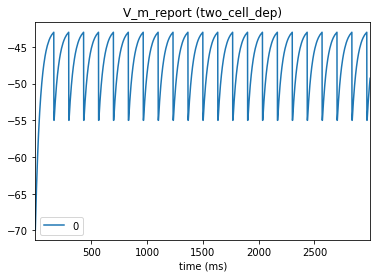

In [20]:
# Presynaptic cell
_ = plot_traces(config_file='config.pointnet.json', report_name='V_m_report', node_ids = [0])

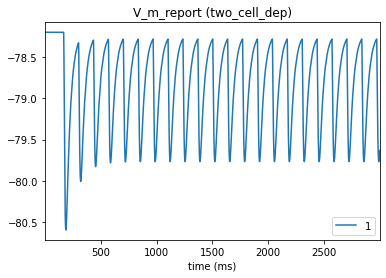

In [21]:
# Postsynaptic cell
_ = plot_traces(config_file='config.pointnet.json', report_name='V_m_report', node_ids = [1])